# Introduction

With this repository I wanted to challenge myself on the task of creating a model which is able to the determine correctly the demand planning.

The repository contains 2 notebooks, this being the second.

In the first notebook I tried to use linear models by applying log transformations to the numerical features to normalize the distribution.
The linear models reached a score of 78%.

After this I decided to use XGBoost and LightGBMR which handle skewed or not normal distributions without issues and focused on feature engineering concerning more metrics which would capture more complex relationship among features, e.g. average sales per week/ month/ etc.

This led to a 92% precision from XGBoost and 91% from LightGBMR, both good results.

The model could be improved with further feature engineering but can be use already as the performance is high.

Business use of this model could be demand planning in E-commerce if we think about replenishment business models in which suppliers inject their items within the service provider's warehouse, allowing the E-commerce platform to plan the units to be ordered from the suppliers to meet the correct level of demand and not having items which would remain unsold, wasting therefore space in the warehouse and also increasing storage cost for the suppliers.

Notebook to apply heavier feature engineering

In [128]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [129]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Demand_Forecasting/train_0irEZ2H.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Demand_Forecasting/test_nfaJ3J5.csv')

train = data1.copy()
test = data2.copy()

train.shape, test.shape

((150150, 9), (13860, 8))

In [130]:
num = train.select_dtypes(include='number')
cat = train.select_dtypes(exclude='number')

num.columns, cat.columns

(Index(['record_ID', 'store_id', 'sku_id', 'total_price', 'base_price',
        'is_featured_sku', 'is_display_sku', 'units_sold'],
       dtype='object'),
 Index(['week'], dtype='object'))

In [131]:
train['price_diff'] = train['base_price'] - train['total_price']
test['price_diff'] = test['base_price'] - test['total_price']

train['discount_applied'] = (train['price_diff'] / 100.0) * train['base_price']
test['discount_applied'] = (test['price_diff'] / 100.0) * test['base_price']

# train['store_sku_id'] = str(train['store_id']) + '_' + str(train['sku_id']) #removing on this notebook as probably redundant
# test['store_sku_id'] = str(test['store_id']) + '_' + str(test['sku_id'])

print('First 3 rows of Train after feature engineering: \n', train.head(3))
print('First 3 rows of Test after feature engineering: \n', test.head(3))



First 3 rows of Train after feature engineering: 
    record_ID      week  store_id  sku_id  total_price  base_price  \
0          1  17/01/11      8091  216418      99.0375    111.8625   
1          2  17/01/11      8091  216419      99.0375     99.0375   
2          3  17/01/11      8091  216425     133.9500    133.9500   

   is_featured_sku  is_display_sku  units_sold  price_diff  discount_applied  
0                0               0          20      12.825         14.346366  
1                0               0          28       0.000          0.000000  
2                0               0          19       0.000          0.000000  
First 3 rows of Test after feature engineering: 
    record_ID      week  store_id  sku_id  total_price  base_price  \
0     212645  16/07/13      8091  216418     108.3000    108.3000   
1     212646  16/07/13      8091  216419     109.0125    109.0125   
2     212647  16/07/13      8091  216425     133.9500    133.9500   

   is_featured_sku  is_displa

In [132]:
#datetime feature engineering

import datetime

train['week'] = pd.to_datetime(train['week'])
test['week'] = pd.to_datetime(test['week'])

train['year'] = train['week'].dt.year
test['year'] = test['week'].dt.year
train['month'] = train['week'].dt.month
test['month'] = test['week'].dt.month
train['weekday'] = train['week'].dt.day_of_week
test['weekday'] = test['week'].dt.day_of_week
train['week_of_year'] = train['week'].dt.isocalendar().week
test['week_of_year'] = test['week'].dt.isocalendar().week


In [133]:
days_map = {
    0 : 1,
    1 : 2,
    2 : 3,
    3 : 4,
    4 : 5,
    5 : 6,
    6 : 7
}

train['weekday'] = train['weekday'].map(days_map)
test['weekday'] = test['weekday'].map(days_map)

train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,year,month,weekday,week_of_year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,12.8250,14.346366,2011,1,1,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0.0000,0.000000,2011,1,1,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0.0000,0.000000,2011,1,1,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,0.0000,0.000000,2011,1,1,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,0.0000,0.000000,2011,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,0.0000,0.000000,2013,9,6,36
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,0.0000,0.000000,2013,9,6,36
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,126.1125,610.116511,2013,9,6,36
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,49.8750,95.591672,2013,9,6,36


In [135]:
agg_series = train.groupby('sku_id')['units_sold'].mean()

train['avg_sales'] = train['sku_id'].map(agg_series)

agg_series2 = train.groupby(['store_id', 'sku_id'])['units_sold'].mean().reset_index()
agg_series2.rename(columns={'units_sold': 'avg_sales_store_sku'}, inplace= True)

train = train.merge(agg_series2, on=['store_id', 'sku_id'], how='left')

agg_series3 = train.groupby(['month', 'store_id', 'sku_id'])['units_sold'].mean().reset_index()
agg_series3.rename(columns={'units_sold' : 'avg_sales_month_store'}, inplace= True)

train = train.merge(agg_series3, on=['month', 'store_id', 'sku_id'], how='left')

agg_series4 = train.groupby(['week_of_year', 'store_id', 'sku_id'])['units_sold'].mean().reset_index()
agg_series4.rename(columns={'units_sold': 'avg_sales_week_store'}, inplace= True)

train = train.merge(agg_series4, on=['week_of_year', 'store_id', 'sku_id'], how='left')

In [137]:
train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,...,year,month,weekday,week_of_year,avg_sales,avg_sales_store_sku_x,avg_sales_month_store_x,avg_sales_store_sku_y,avg_sales_month_store_y,avg_sales_week_store
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,12.8250,...,2011,1,1,3,88.923869,26.376923,30.250000,26.376923,30.250000,32.000000
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0.0000,...,2011,1,1,3,72.182664,28.307692,46.250000,28.307692,46.250000,62.000000
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0.0000,...,2011,1,1,3,34.019231,25.669231,25.250000,25.669231,25.250000,29.333333
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,0.0000,...,2011,1,1,3,46.821206,29.107692,26.583333,29.107692,26.583333,38.666667
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,0.0000,...,2011,1,1,3,62.312747,29.469231,31.500000,29.469231,31.500000,39.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,0.0000,...,2013,9,6,36,68.510537,61.384615,35.000000,61.384615,35.000000,40.000000
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,0.0000,...,2013,9,6,36,60.407560,53.023077,29.555556,53.023077,29.555556,27.333333
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,126.1125,...,2013,9,6,36,33.212139,21.553846,27.888889,21.553846,27.888889,25.333333
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,49.8750,...,2013,9,6,36,21.838213,14.100000,12.111111,14.100000,12.111111,14.666667


In [144]:
train = train.drop(columns='week')

In [145]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [146]:
#regression issues

def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "LightGBMR" : LGBMRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
   
    return results_df, model


In [147]:
from sklearn.model_selection import train_test_split

X = train.drop(columns='units_sold')
y = train['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [148]:
gradient_result_df, gradient_model = train_and_eval_models(X_train, X_test, y_train, y_test)

print(gradient_result_df)

Starting the training process.
Training model: LightGBMR
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2736
[LightGBM] [Info] Number of data points in the train set: 120120, number of used features: 19
[LightGBM] [Info] Start training from score 51.789352
Training model: XGB

Model Performance Summary:
       Model  Train MAE   Test MAE  Train RMSE  Test RMSE  Train R2   Test R2
0  LightGBMR   9.852202  10.054506   16.057359  16.992299  0.930518  0.912000
1        XGB   8.598605   9.392675   12.832457  16.067110  0.955624  0.921322


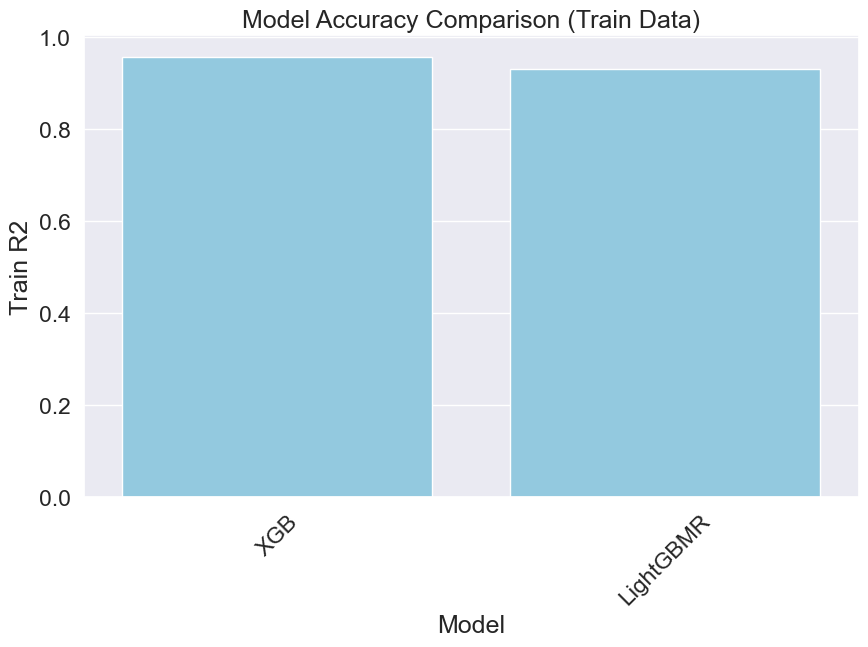

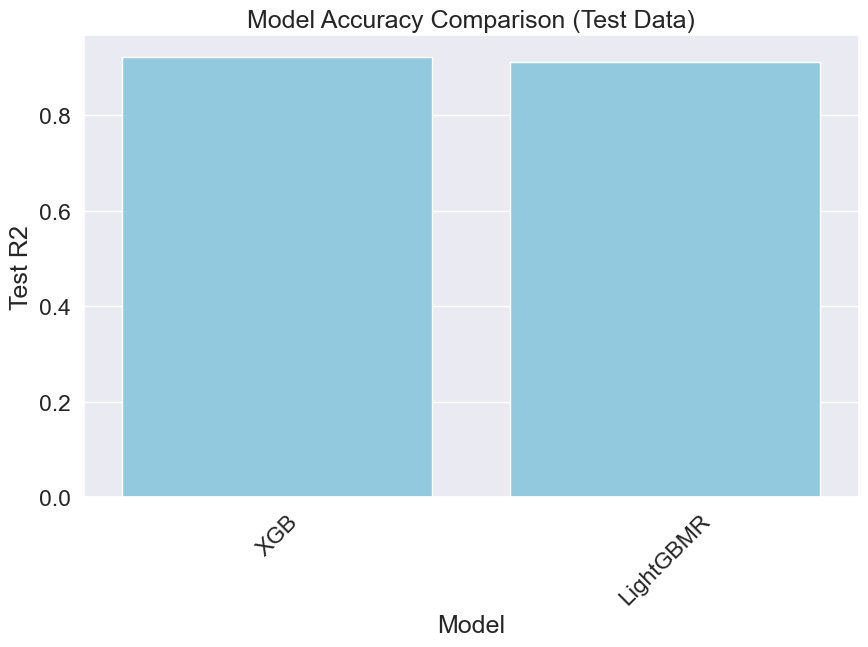

In [150]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train R2", data=gradient_result_df.sort_values(by='Train R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R2", data=gradient_result_df.sort_values(by='Test R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()

In [152]:
#Saving the baseline model
import pickle

with open('gradient_model.pkl', 'wb') as file:
    pickle.dump(gradient_model, file)

print("Model saved successfully to 'gradient_model.pkl'")

Model saved successfully to 'gradient_model.pkl'
